In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pymc3 as pm
import seaborn as sb
import corner

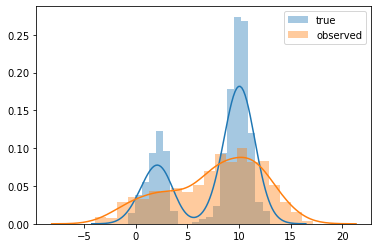

In [5]:
#first distribution
Amu=10
Asigma=1

#second distribution
Bmu=2
Bsigma=1

obs_err=2.5

Qfactor=0.7            #fraction of data that belongs to A population
N=500
Apop=np.random.randn(int(N*Qfactor))*Asigma+Amu
Bpop=np.random.randn(N-int(N*Qfactor))*Bsigma+Bmu
Xtrue=np.append(Apop,Bpop)
Xobs=np.random.randn(N)*obs_err+Xtrue

ax=sb.distplot(Xtrue,bins=20,label='true')
ax=sb.distplot(Xobs,bins=20,label='observed')
plt.legend()
plt.show()

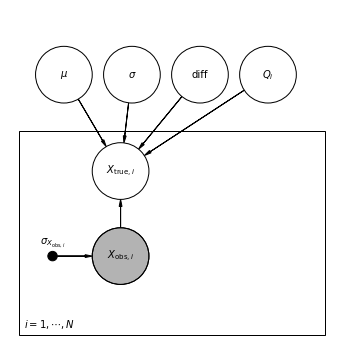

In [10]:
import daft
pgm = daft.PGM([3,3], grid_unit=4, node_unit=2)
# Hierarchical parameters.
pgm.add_node(daft.Node("mu1", r"$\mu_1$", 0.5, 2.6))
pgm.add_node(daft.Node("sigma1", r"$\sigma_1$", 1.1, 2.6))
pgm.add_node(daft.Node("diff", "diff", 1.7, 2.6))
pgm.add_node(daft.Node("Q", r"$Q_i$", 2.3, 2.6))
# Add latent variables 
pgm.add_node(daft.Node("X_true", r"$X_{{\rm true},i}$", 1, 1.75))
# Data.
pgm.add_node(daft.Node("X_obs", r"$X_{{\rm obs},i}$", 1, 1, observed=True))
pgm.add_node(daft.Node("Xerr", r"$\sigma_{X_{{\rm obs},i}}$", 0.4, 1.0, fixed=True, offset=[0.0,0.4]))
# Add in the edges.
pgm.add_edge("mu", "X_true")
pgm.add_edge("sigma", "X_true")
pgm.add_edge("diff", "X_true")
pgm.add_edge("Q", 'X_true')
pgm.add_edge("X_obs", "X_true")
pgm.add_edge("Xerr", "X_obs")
# And a plate.
pgm.add_plate(daft.Plate([0.1, 0.4, 2.7, 1.7], label=r"$i = 1, \cdots, N$",
    shift=-0.1))
# Render and save.
pgm.render()

In [13]:
model=pm.Model()
with model:
    #priors
    mu1=pm.Normal('mu1',7.5,10)
    sigma1=pm.Lognormal('sigma1',np.log(1),0.3)
    diff=pm.Lognormal('diff',np.log(0.5),1)
    sigma2=pm.Lognormal('sigma2',np.log(1),0.3)
    BoundN=pm.Bound(pm.Normal,lower=0,upper=1)
    Q=BoundN('Q',0.5,0.2)
    
    #true
    mu2=mu1-diff
    pop1=pm.Normal('true1',mu1,sigma1,shape=int(N*Q))
    pop2=pm.Normal('true2',mu2,sigma2,shape=N-int(N*Q))
    true=np.append(pop1,pop2) #????
    
    #observed
    X_obs=pm.Normal('X_obs',true,obs_err,observed=Xobs)

with model:
    trace=pm.sample(tune=4000,chains=4,target_accept=0.9)

TypeError: int() argument must be a string, a bytes-like object or a number, not 'TensorVariable'